In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ap import PointNetAbstractorPredictor
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data,\
                                                points_w_normals_extension

from tf_lab.autopredictors.scripts import virt_scan_data as vscan

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
complete_n_samples = 4096
incomplete_n_samples = 2048

predict_normals = True
# experiment_name = '10_vscan_emd_' + str(incomplete_n_samples) + '_' + str(complete_n_samples) + 'pts'
experiment_name = 'scratch'

do_training = True
do_plotting = False
first_time_running = True
load_model = False
load_test_data = True

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

n_input = [incomplete_n_samples, 3]
n_output = [complete_n_samples, 3]

if predict_normals:
    n_extra_pred = [complete_n_samples, 3]
    decoder_last_dim = n_output[0]  * (n_output[1] + n_extra_pred[1])
else:
    n_extra_pred = None
    decoder_last_dim = np.prod(n_output)

Give me the class type.
chair


In [4]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/', \
                             str(complete_n_samples) + '_with_normals', class_syn_id)


train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/')
train_dir = osp.join(train_dir, experiment_name)

create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch'

In [5]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, points_w_normals_extension)

full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, \
                                            loader=pio._load_crude_pcloud_with_normal_and_model_info,\
                                                                        n_threads=25)


print '%d files containing complete point clouds with normals were found.' % (len(full_pclouds), )

6778 files containing complete point clouds with normals were found.


In [24]:
v_scan_top_dir = osp.join(top_data_dir, 'From_Matthias/shapenet_dim32_sdf_pc', class_syn_id)
search_pattern = '.ply'
   
if do_training:
    train_id_file = osp.join(top_data_dir, 'From_Matthias/train_test_models/train_models_with_scan_id.txt')
    
    train_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, train_id_file, class_syn_id,
                                                      full_pclouds, full_model_names, n_threads=25,
                                                      n_samples=incomplete_n_samples, search_pattern=search_pattern)


if load_test_data:
    test_id_file = osp.join(top_data_dir, 'From_Matthias/train_test_models/test_models_with_scan_id.txt')
    test_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, test_id_file, class_syn_id, 
                                                      full_pclouds, full_model_names, n_threads=25,
                                                      n_samples=incomplete_n_samples, search_pattern=search_pattern)

6000 incomplete point clouds were loaded.


0.38330078125 0.111083984375


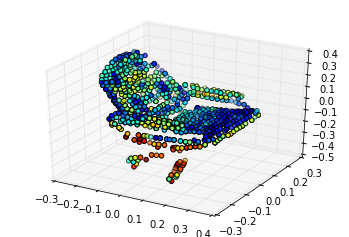

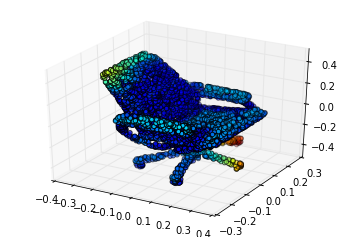

In [7]:
# # TRY ME to see that the matched chairs are ok.
from tf_lab.autopredictors.evaluate import accuracy_of_completion, coverage_of_completion

pp = train_data.next_batch(1)
pinc = pp[2].reshape(n_input)
pcom = pp[0][:, :, :3].reshape(complete_n_samples, 3)

    
score1, c1 = accuracy_of_completion(pinc, pcom, 0.02, ret_dists=True)
score2, c2 = coverage_of_completion(pcom, pinc, 0.02, ret_dists=True)
print score1, score2

Point_Cloud(points=pinc).plot(c=c1);
Point_Cloud(points=pcom).plot(c=c2);

In [9]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    decoder_args = {'layer_sizes': [1024, decoder_last_dim],  # TODO - Try one layer deeper
                    'non_linearity': tf.nn.tanh
                   }
    
    encoder_args = {'non_linearity': tf.nn.tanh
                   }

    conf = Conf(
                n_input = n_input,
                denoising = True,
                training_epochs = 200,
                batch_size = 40,
                loss = 'emd',
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.00002,
                gauss_augment = {'mu': 0, 'sigma': 0.01},
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                encoder_args = encoder_args,                
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,                
               )
    
    
    conf.n_output = n_output   # TODO - Wrap seperately
    conf.n_extra_pred = n_extra_pred
    conf.consistent_io = False
    
    conf.relative_loss_weight = 1.0

    conf.experiment_name = experiment_name

    conf.save(osp.join(conf.train_dir, 'configuration'))

In [54]:
reset_tf_graph()
set_visible_GPUs([0])
ap = PointNetAbstractorPredictor(experiment_name, conf)

if do_training:
    ap.train(train_data, conf)

else:
    saved_epochs = read_saved_epochs(conf.train_dir)
    ap.restore_model(train_dir, saved_epochs[-1], verbose=True)

Model restored in epoch 100.


In [90]:
test =  
print np.sum(np.abs(pred_normals[0]))
print np.sum(np.abs(original_data[0][:,3:]))

629.510899636
5370.18


In [53]:
# recon, data_loss, feed_data, ids, original_data, pred_normals = evaluate(ap, test_data, conf)

# k = 16
# Point_Cloud(points=feed_data[k]).plot();

# Point_Cloud(points=recon[1]).plot();

# Point_Cloud(points=original_data[k][:,:3]).plot();
# print ids[k]

create_dir('/orions4-zfs/projects/lins2/pypoisson/dirty_testing_3/')

for i in xrange(100):
#     combined = np.hstack((recon[i], original_data[i][:,:3]))
    combined = original_data[i]
    np.savetxt('/orions4-zfs/projects/lins2/pypoisson//' + ids[i] +'predictions.txt', combined)
    
# original_data[i][:,:3]

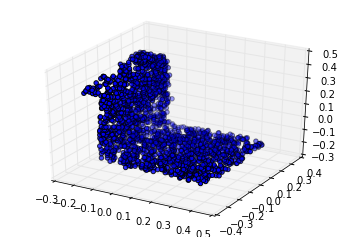

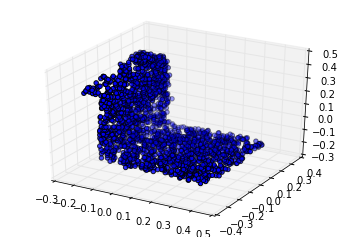

In [85]:
# k = 5
# Point_Cloud(points=feed_data[k]).plot();
# Point_Cloud(points=recon[k]).plot();
# pc_gt = original_data[k][:,:3]
# n_gt = original_data[k][:,3:]
# Point_Cloud(points=pc_gt + 0.01*n_gt).plot();

In [10]:
if do_plotting:
    saved_epochs = read_saved_epochs(conf.train_dir)
#     plot_epochs = select_first_last_and_k(saved_epochs, 13)
#     stats = eval_model(ae, conf, [train_data, test_data], epochs=plot_epochs)
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')
#     plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)
    last_epoch = saved_epochs[-1]
#     save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
#     plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)    
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)